In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
con = sqlite3.connect('imdb_small_indexed.db')
cur = con.cursor()

Создаю таблицу, называю столбцы

In [11]:
cur.execute("""
CREATE TABLE myten_films (
    title_id INT, 
    title TEXT, 
    premiered INT,
    rating REAL,
    PRIMARY KEY (title_id)
)
""")

Делаю запрос к базе данных с Яндекс.Диска, чтобы выбрать нужные фильмы

In [12]:
myfilms = """
SELECT titles.title_id, title, premiered, rating
FROM titles
    JOIN rating ON titles.title_id = rating.title_id
WHERE title in ("Fight Club", "Big Fish", "Interstellar", "Matrix", "Charlie and the Chocolate Factory", "Star Wars: Episode VI - Return of the Jedi", "Ghost in the Shell", "The Devil Wears Prada", "Forrest Gump", "The Fifth Element")
"""

In [13]:
cur.execute(myfilms)

In [14]:
data = cur.fetchall()

Перемещаю данные отфильтрованной таблицы в свою таблицу

In [15]:
cur.executemany("INSERT INTO myten_films VALUES (?, ?, ?, ?)", data)
con.commit()

Для того, чтобы добавить свой столбец к уже существующей табличке, переделываю в датафрейм

In [16]:
df = pd.read_sql_query(myfilms, con=con)
df

,title_id,title,premiered,rating
0,86190,Star Wars: Episode VI - Return of the Jedi,1983,8.3
1,106062,Matrix,1993,7.8
2,109830,Forrest Gump,1994,8.8
3,113568,Ghost in the Shell,1995,8.0
4,119116,The Fifth Element,1997,7.7
5,137523,Fight Club,1999,8.8
6,319061,Big Fish,2003,8.0
7,367594,Charlie and the Chocolate Factory,2005,6.6
8,458352,The Devil Wears Prada,2006,6.9
9,816692,Interstellar,2014,8.6


чищу список от омонимии (некоторые фильмы имели несколько экранизаций)

In [17]:
df = df.drop(df[(df.title == 'Matrix') & (df.premiered > 2019)].index)
df = df.drop(df[(df.title == 'Big Fish') & (df.premiered > 2011)].index)
df = df.drop(df[(df.title == 'Ghost in the Shell') & (df.premiered < 1996)].index)

In [18]:
df

,title_id,title,premiered,rating
0,86190,Star Wars: Episode VI - Return of the Jedi,1983,8.3
1,106062,Matrix,1993,7.8
2,109830,Forrest Gump,1994,8.8
4,119116,The Fifth Element,1997,7.7
5,137523,Fight Club,1999,8.8
6,319061,Big Fish,2003,8.0
7,367594,Charlie and the Chocolate Factory,2005,6.6
8,458352,The Devil Wears Prada,2006,6.9
9,816692,Interstellar,2014,8.6
11,1219827,Ghost in the Shell,2017,6.3


Добавляю свой рейтинг

In [19]:
df['my_rating'] = [8, 10, 10, 7, 10, 9, 9, 9, 6, 6]
df

,title_id,title,premiered,rating,my_rating
0,86190,Star Wars: Episode VI - Return of the Jedi,1983,8.3,8
1,106062,Matrix,1993,7.8,10
2,109830,Forrest Gump,1994,8.8,10
4,119116,The Fifth Element,1997,7.7,7
5,137523,Fight Club,1999,8.8,10
6,319061,Big Fish,2003,8.0,9
7,367594,Charlie and the Chocolate Factory,2005,6.6,9
8,458352,The Devil Wears Prada,2006,6.9,9
9,816692,Interstellar,2014,8.6,6
11,1219827,Ghost in the Shell,2017,6.3,6


Перевожу обратно в базу данных

In [20]:
df.to_sql('topten', con=con)

Создаю индекс

In [21]:
cur.execute("""
CREATE INDEX ratedfilms ON topten (my_rating)
""")

Запрос с WHERE

In [22]:
cur.execute("""
SELECT 
    GROUP_CONCAT(my_rating) as mytoprat
FROM topten
WHERE my_rating > 8
""")
cur.fetchall()

[('9,9,9,10,10,10',)]

Запрос с WHERE, LIMIT, HAVING, GROUP BY

In [23]:
cur.execute("""
SELECT title, premiered, rating, my_rating
FROM topten
WHERE my_rating > rating 
GROUP BY my_rating
HAVING premiered < 2005
LIMIT 5
""")
data = cur.fetchall()

График по этому запросу, где я сравниваю все фильмы до 2005 года по рейтингу моему и данному изначально, а грфик показывает, какие оценки были мною поставлены этим фильмам

In [24]:
df = pd.DataFrame(data, columns=['title', 'premiered','rating', 'my_rating'])

Text(0, 0.5, 'оценка')

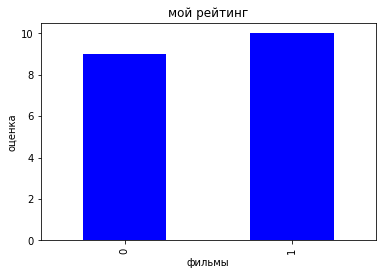

In [25]:
df['my_rating'].plot.bar(color='blue');
plt.title('мой рейтинг')
plt.xlabel('фильмы')
plt.ylabel('оценка')

Запрос с WHERE, GROUP BY, AVG

In [26]:
cur.execute("""
SELECT 
    title, premiered,
    AVG(my_rating) as average_rat
FROM topten
WHERE premiered < 2000
GROUP BY premiered
""")
cur.fetchall()

[('Star Wars: Episode VI - Return of the Jedi', 1983, 8.0),
 ('Matrix', 1993, 10.0),
 ('Forrest Gump', 1994, 10.0),
 ('The Fifth Element', 1997, 7.0),
 ('Fight Club', 1999, 10.0)]

Запрос с MAX, LIMIT

In [27]:
cur.execute("""
SELECT 
    title, 
MAX (rating + my_rating) as real_maX
FROM topten 
LIMIT 1
""")
cur.fetchall()

[('Forrest Gump', 18.8)]

Запрос с  COUNT, WHERE

In [28]:
cur.execute("""
SELECT 
    COUNT(title) as topfilms
FROM topten
WHERE rating > 7 and my_rating > 8
""")
cur.fetchall()

[(4,)]

Запрос с GROUP BY, WHERE

In [29]:
cur.execute("""
SELECT 
    title, premiered
FROM topten
WHERE premiered < 2000 or premiered > 2010
GROUP BY premiered
""")
cur.fetchall()

[('Star Wars: Episode VI - Return of the Jedi', 1983),
 ('Matrix', 1993),
 ('Forrest Gump', 1994),
 ('The Fifth Element', 1997),
 ('Fight Club', 1999),
 ('Interstellar', 2014),
 ('Ghost in the Shell', 2017)]